In [1]:
import pandas as pd
import yaml
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
)
import numpy as np
from sim_utils.modeling import create_model, create_reg_model, update_config
from utils.quack import Quack

In [2]:

pbp = Quack.query('select * from pbp where season > 2021')
small = pbp.loc[pbp.season > 2021].dropna(how="all", axis=1)
print(pbp.columns)

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'out_of_bounds', 'home_opening_kickoff', 'qb_epa', 'xyac_epa',
       'xyac_mean_yardage', 'xyac_median_yardage', 'xyac_success', 'xyac_fd',
       'xpass', 'pass_oe'],
      dtype='object', length=372)


In [3]:
desc_cols = [
    "play_id",
    "game_id",
    "home_team",
    "away_team",
    "game_half",
    "posteam",
    "side_of_field",
    "desc",
]


In [4]:
play_type_mapping = {
    "field_goal": 0,
    "no_play": 1,
    "pass": 2,
    "punt": 3,
    "qb_kneel": 4,
    "qb_spike": 5,
    "run": 6,
    np.nan: 7,
}

In [5]:
game_context_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    # "yards_gained",
    "posteam_score",
    # "total_away_score",
    "score_differential",
    "quarter_seconds_remaining",
    "half_seconds_remaining",
    "game_seconds_remaining",
    "wind",
    "temp",
    "spread_line",
    "total_line",
]

pbp["play_type_enc"] = pbp["play_type"].map(play_type_mapping)
y_col = "play_type_enc"
data = pbp.loc[
    (~pbp.down.isna()) & (~pbp.rush_attempt.isna()) & ~(pbp.play_type.isna())
][game_context_cols + [y_col]]

In [6]:
team_receiver_stats = pd.read_csv("data/team_receiver_stats.csv", index_col=0)
receiver_cols = [x for x in team_receiver_stats.columns if "ception" in x] + [
    x for x in team_receiver_stats.columns if "arget" in x
] + [x for x in team_receiver_stats.columns if "ppr" in x] + [
    x for x in team_receiver_stats.columns if "pct" in x] + [
        x for x in team_receiver_stats.columns if "per_catch" in x
    ]
sorted(receiver_cols)

['fantasy_points_ppr_roll_RB_0',
 'fantasy_points_ppr_roll_RB_1',
 'fantasy_points_ppr_roll_TE_0',
 'fantasy_points_ppr_roll_TE_1',
 'fantasy_points_ppr_roll_TE_2',
 'fantasy_points_ppr_roll_WR_0',
 'fantasy_points_ppr_roll_WR_1',
 'fantasy_points_ppr_roll_WR_2',
 'fantasy_points_ppr_roll_WR_3',
 'fantasy_points_ppr_roll_WR_4',
 'offense_pct_roll_RB_0',
 'offense_pct_roll_RB_1',
 'offense_pct_roll_TE_0',
 'offense_pct_roll_TE_1',
 'offense_pct_roll_TE_2',
 'offense_pct_roll_WR_0',
 'offense_pct_roll_WR_1',
 'offense_pct_roll_WR_2',
 'offense_pct_roll_WR_3',
 'offense_pct_roll_WR_4',
 'receptions_roll_RB_0',
 'receptions_roll_RB_1',
 'receptions_roll_TE_0',
 'receptions_roll_TE_1',
 'receptions_roll_TE_2',
 'receptions_roll_WR_0',
 'receptions_roll_WR_1',
 'receptions_roll_WR_2',
 'receptions_roll_WR_3',
 'receptions_roll_WR_4',
 'target_share_roll_RB_0',
 'target_share_roll_RB_1',
 'target_share_roll_TE_0',
 'target_share_roll_TE_1',
 'target_share_roll_TE_2',
 'target_share_roll_WR_0'

In [7]:
team_rusher_cols = ['carries_roll_QB_0',
 'carries_roll_QB_1',
 'carries_roll_RB_0',
 'carries_roll_RB_1',
 'carries_roll_RB_2',
 'carries_roll_TE_0',
 'carries_roll_WR_0',
 'fantasy_points_ppr_roll_QB_0',
 'fantasy_points_ppr_roll_QB_1',
 'fantasy_points_ppr_roll_RB_0',
 'fantasy_points_ppr_roll_RB_1',
 'fantasy_points_ppr_roll_RB_2',
 'fantasy_points_ppr_roll_TE_0',
 'fantasy_points_ppr_roll_WR_0',
 'yards_per_carry_roll_QB_0',
 'yards_per_carry_roll_QB_1',
 'yards_per_carry_roll_RB_0',
 'yards_per_carry_roll_RB_1',
 'yards_per_carry_roll_RB_2',
 'yards_per_carry_roll_TE_0',
 'yards_per_carry_roll_WR_0',
 'offense_pct_roll_QB_0',
 'offense_pct_roll_QB_1',
 'offense_pct_roll_RB_0',
 'offense_pct_roll_RB_1',
 'offense_pct_roll_RB_2',
 'offense_pct_roll_TE_0',
 'offense_pct_roll_WR_0',
 'rushing_first_downs_roll_QB_0',
 'rushing_first_downs_roll_QB_1',
 'rushing_first_downs_roll_RB_0',
 'rushing_first_downs_roll_RB_1',
 'rushing_first_downs_roll_RB_2',
 'rushing_first_downs_roll_TE_0',
 'rushing_first_downs_roll_WR_0',
 'rushing_tds_roll_QB_0',
 'rushing_tds_roll_QB_1',
 'rushing_tds_roll_RB_0',
 'rushing_tds_roll_RB_1',
 'rushing_tds_roll_RB_2',
 'rushing_tds_roll_TE_0',
 'rushing_tds_roll_WR_0',
 'rushing_yards_roll_QB_0',
 'rushing_yards_roll_QB_1',
 'rushing_yards_roll_RB_0',
 'rushing_yards_roll_RB_1',
 'rushing_yards_roll_RB_2',
 'rushing_yards_roll_TE_0',
 'rushing_yards_roll_WR_0',
 'last_rusher_drive',
 'last_rusher_team']

In [8]:
def get_rusher_number(row):
    """0-2 is RB, 3-7 is WR, 8-10 is TE"""
    for num, col_name in enumerate(
        [
            "gsis_id_RB_0",
            "gsis_id_RB_1",
            "gsis_id_RB_2",
            "gsis_id_QB_0",
            "gsis_id_QB_1",
            "gsis_id_TE_0",
            "gsis_id_WR_0",
        ]
    ):
        if row[col_name] == row["rusher_player_id"]:
            return num
    return None

In [9]:
team_rb_stats = pd.read_csv("data/team_rushers.csv", index_col=0)
comb = pbp.merge(
    team_rb_stats,
    left_on=["posteam", "season", "week"],
    right_on=["team", "season", "week"],
)

comb["rusher_depth_num"] = comb.apply(get_rusher_number, axis=1)
rushes = comb.loc[(~comb.rusher_depth_num.isna()) & (~comb.yards_gained.isna())].copy(
    deep=True
)
rushes["last_rusher_drive"] = (
    rushes.groupby(["game_id", "drive", "posteam"])["rusher_depth_num"]
    .shift()
    .fillna(-1)
)
rushes["last_rusher_team"] = (
    rushes.groupby(["game_id", "posteam"])["rusher_depth_num"].shift().fillna(-1)
)
rushes[(game_context_cols + team_rusher_cols)]

,yardline_100,down,goal_to_go,ydstogo,posteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,...,rushing_tds_roll_WR_0,rushing_yards_roll_QB_0,rushing_yards_roll_QB_1,rushing_yards_roll_RB_0,rushing_yards_roll_RB_1,rushing_yards_roll_RB_2,rushing_yards_roll_TE_0,rushing_yards_roll_WR_0,last_rusher_drive,last_rusher_team
1,78.0,1.0,0.0,10.0,0.0,0.0,896.0,1796.0,3596.0,NaN,...,1.875002e-01,2.599497,0.0,64.288117,NaN,0.000000,0.0,2.838214,-1.0,-1.0
3,59.0,2.0,0.0,10.0,0.0,0.0,865.0,1765.0,3565.0,NaN,...,1.875002e-01,2.599497,0.0,64.288117,NaN,0.000000,0.0,2.838214,0.0,0.0
8,64.0,3.0,0.0,2.0,0.0,0.0,761.0,1661.0,3461.0,NaN,...,0.000000e+00,66.229904,0.0,NaN,30.505009,4.467481,0.0,0.000000,-1.0,-1.0
13,89.0,1.0,0.0,10.0,0.0,0.0,589.0,1489.0,3289.0,NaN,...,1.875002e-01,2.599497,0.0,64.288117,NaN,0.000000,0.0,2.838214,-1.0,0.0
16,83.0,1.0,0.0,10.0,0.0,0.0,507.0,1407.0,3207.0,NaN,...,1.875002e-01,2.599497,0.0,64.288117,NaN,0.000000,0.0,2.838214,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137242,44.0,2.0,0.0,10.0,31.0,31.0,222.0,222.0,222.0,NaN,...,1.415804e-07,15.823812,0.0,49.310259,40.299105,3.272327,0.0,0.056623,2.0,2.0
137244,35.0,4.0,0.0,1.0,31.0,31.0,123.0,123.0,123.0,NaN,...,1.415804e-07,15.823812,0.0,49.310259,40.299105,3.272327,0.0,0.056623,2.0,2.0
137245,25.0,1.0,0.0,10.0,31.0,31.0,119.0,119.0,119.0,NaN,...,1.415804e-07,15.823812,0.0,49.310259,40.299105,3.272327,0.0,0.056623,2.0,2.0
137246,26.0,2.0,0.0,11.0,31.0,31.0,76.0,76.0,76.0,NaN,...,1.415804e-07,15.823812,0.0,49.310259,40.299105,3.272327,0.0,0.056623,3.0,3.0


In [10]:
rushes[['posteam','game_id', 'last_rusher_team', 'rusher_depth_num']].head(20)

,posteam,game_id,last_rusher_team,rusher_depth_num
1,NYJ,2022_01_BAL_NYJ,-1.0,0.0
3,NYJ,2022_01_BAL_NYJ,0.0,0.0
8,BAL,2022_01_BAL_NYJ,-1.0,3.0
13,NYJ,2022_01_BAL_NYJ,0.0,1.0
16,NYJ,2022_01_BAL_NYJ,1.0,0.0
17,NYJ,2022_01_BAL_NYJ,0.0,0.0
21,BAL,2022_01_BAL_NYJ,3.0,1.0
25,NYJ,2022_01_BAL_NYJ,0.0,0.0
44,NYJ,2022_01_BAL_NYJ,0.0,1.0
46,NYJ,2022_01_BAL_NYJ,1.0,1.0


In [11]:
comb.loc[comb.rusher_player_name=='J.Hurts'][['home_team','season','week','rusher_player_id','rusher_depth_num', 'gsis_id_QB_0',
                                              'gsis_id_QB_1','desc']]

,home_team,season,week,rusher_player_id,rusher_depth_num,gsis_id_QB_0,gsis_id_QB_1,desc
1844,DET,2022,1,00-0036389,3.0,00-0036389,0,(10:18) (Shotgun) 1-J.Hurts left end pushed ob...
1845,DET,2022,1,00-0036389,3.0,00-0036389,0,(9:35) (Shotgun) 1-J.Hurts scrambles up the mi...
1849,DET,2022,1,00-0036389,3.0,00-0036389,0,(8:42) (Shotgun) 1-J.Hurts scrambles up the mi...
1862,DET,2022,1,00-0036389,3.0,00-0036389,0,(4:17) (Shotgun) 1-J.Hurts scrambles left end ...
1864,DET,2022,1,00-0036389,3.0,00-0036389,0,(2:49) (Shotgun) 1-J.Hurts scrambles left end ...
...,...,...,...,...,...,...,...,...
133435,PHI,2025,13,00-0036389,3.0,00-0036389,0,(:24) (Shotgun) 1-J.Hurts up the middle to CHI...
136526,LAC,2025,14,00-0036389,3.0,00-0036389,0,"(5:29) (No Huddle, Shotgun) 1-J.Hurts left tac..."
136527,LAC,2025,14,00-0036389,3.0,00-0036389,0,(4:47) (Shotgun) 1-J.Hurts scrambles right end...
136554,LAC,2025,14,00-0036389,3.0,00-0036389,0,(9:14) (Shotgun) 1-J.Hurts scrambles left end ...


In [12]:
rushes['rushing_yards_roll_RB_0'].max()

np.float64(150.2021694169472)

In [13]:
choose_rusher_cols = (
    game_context_cols + team_rusher_cols
)
choose_rusher_model = create_model(
    rushes.fillna(0), x_cols=choose_rusher_cols, y_col="rusher_depth_num"
)
model_path = "models/choose_rusher.joblib"
joblib.dump(choose_rusher_model, model_path)
_ = """
Accuracy: 0.69
Confusion Matrix:
array([[17449,  1485,   433,   442,    45,     3,     4],
       [ 3336,  5003,   321,   309,    25,     1,     0],
       [ 1227,   518,  1998,   138,    12,     1,     0],
       [ 1857,   630,   241,  2019,    20,     0,     0],
       [  264,    91,    64,    98,   220,     0,     2],
       [   17,     4,     8,     2,     0,     7,     0],
       [  157,    45,    20,     8,     2,     0,     3]], dtype=int64)
"""

C:\Users\Sharedw\AppData\Local\Temp\ipykernel_40824\2932838210.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rushes.fillna(0), x_cols=choose_rusher_cols, y_col="rusher_depth_num"


Accuracy: 0.67
Confusion Matrix:
[[3702  334   65  153   24    1    0]
 [ 778 1032   48   87   16    1    0]
 [ 204   88  235   41    3    0    1]
 [ 502  145   47  520    3    0    1]
 [  69   27   15    7   71    0    0]
 [  14    2    0    1    0    0    0]
 [  52   10    3    0    0    0    0]]


In [14]:
rusher_idx_to_pos = {
    idx: col_name.split("id_")[-1]
    for idx, col_name in enumerate(
        [
            "gsis_id_RB_0",
            "gsis_id_RB_1",
            "gsis_id_RB_2",
            "gsis_id_QB_0",
            "gsis_id_QB_1",
            "gsis_id_TE_0",
            "gsis_id_WR_0",
        ]
    )
}
rusher_idx_to_pos

{0: 'RB_0', 1: 'RB_1', 2: 'RB_2', 3: 'QB_0', 4: 'QB_1', 5: 'TE_0', 6: 'WR_0'}

In [15]:
feature_config = {
	'choose_rusher_model': {
    "feature_cols": choose_rusher_cols,
    'rusher_idx_to_pos': rusher_idx_to_pos,
	'model_path': model_path
}
}
feature_config


{'choose_rusher_model': {'feature_cols': ['yardline_100',
   'down',
   'goal_to_go',
   'ydstogo',
   'posteam_score',
   'score_differential',
   'quarter_seconds_remaining',
   'half_seconds_remaining',
   'game_seconds_remaining',
   'wind',
   'temp',
   'spread_line',
   'total_line',
   'carries_roll_QB_0',
   'carries_roll_QB_1',
   'carries_roll_RB_0',
   'carries_roll_RB_1',
   'carries_roll_RB_2',
   'carries_roll_TE_0',
   'carries_roll_WR_0',
   'fantasy_points_ppr_roll_QB_0',
   'fantasy_points_ppr_roll_QB_1',
   'fantasy_points_ppr_roll_RB_0',
   'fantasy_points_ppr_roll_RB_1',
   'fantasy_points_ppr_roll_RB_2',
   'fantasy_points_ppr_roll_TE_0',
   'fantasy_points_ppr_roll_WR_0',
   'yards_per_carry_roll_QB_0',
   'yards_per_carry_roll_QB_1',
   'yards_per_carry_roll_RB_0',
   'yards_per_carry_roll_RB_1',
   'yards_per_carry_roll_RB_2',
   'yards_per_carry_roll_TE_0',
   'yards_per_carry_roll_WR_0',
   'offense_pct_roll_QB_0',
   'offense_pct_roll_QB_1',
   'offense_pct

In [16]:
update_config(feature_config)

In [17]:
passes = pbp.loc[(~pbp.receiver_player_id.isna()) & (pbp.play_type_enc == 2)].copy(
    deep=True
)
passes = passes.merge(
    team_receiver_stats,
    left_on=["posteam", "season", "week"],
    right_on=["team", "season", "week"],
)
passes.sample(3)


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,fantasy_points_ppr_roll_RB_0,fantasy_points_ppr_roll_RB_1,offense_snaps_roll_RB_0,offense_snaps_roll_RB_1,offense_pct_roll_RB_0,offense_pct_roll_RB_1,yards_per_catch_roll_RB_0,yards_per_catch_roll_RB_1,yards_per_target_roll_RB_0,yards_per_target_roll_RB_1
5544,1893.0,2022_06_MIN_MIA,2022101604,MIA,MIN,REG,6,MIA,home,MIN,...,9.830079,7.893190,28.286114,31.794023,0.457252,0.516038,6.364953,6.613226,5.781647,6.006402
59441,349.0,2025_09_IND_PIT,2025110206,PIT,IND,REG,9,IND,away,PIT,...,26.842941,13.619093,52.777716,36.171033,0.840978,0.501504,6.663916,7.332788,6.822569,6.978182
60747,62.0,2025_11_BAL_CLE,2025111610,CLE,BAL,REG,11,CLE,home,BAL,...,12.943418,4.761616,30.353737,15.170072,0.473401,0.245000,3.576157,5.623687,4.170380,5.695551


In [18]:
def get_receiver_number(row):
    """0-2 is RB, 3-7 is WR, 8-10 is TE"""
    for num, col_name in enumerate(
        [
            "gsis_id_WR_0",
            "gsis_id_WR_1",
            "gsis_id_WR_2",
            "gsis_id_WR_3",
            "gsis_id_WR_4",
            "gsis_id_TE_0",
            "gsis_id_TE_1",
            "gsis_id_TE_2",
            "gsis_id_RB_0",
            "gsis_id_RB_1",
        ]
    ):
        if row[col_name] == row["receiver_player_id"]:
            return num
    return None


In [19]:
receiver_idx_to_pos = {
    idx: col_name.split("id_")[-1]
    for idx, col_name in enumerate(
        [
            "gsis_id_WR_0",
            "gsis_id_WR_1",
            "gsis_id_WR_2",
            "gsis_id_WR_3",
            "gsis_id_WR_4",
            "gsis_id_TE_0",
            "gsis_id_TE_1",
            "gsis_id_TE_2",
            "gsis_id_RB_0",
            "gsis_id_RB_1",
        ]
    )
}
receiver_idx_to_pos


{0: 'WR_0',
 1: 'WR_1',
 2: 'WR_2',
 3: 'WR_3',
 4: 'WR_4',
 5: 'TE_0',
 6: 'TE_1',
 7: 'TE_2',
 8: 'RB_0',
 9: 'RB_1'}

In [20]:
passes["receiver_idx"] = passes.apply(get_receiver_number, axis=1)
passes[
    [
        "posteam",
        "gsis_id_WR_0",
        "gsis_id_WR_1",
        "gsis_id_WR_2",
        "gsis_id_WR_3",
        "gsis_id_WR_4",
        "gsis_id_TE_0",
        "gsis_id_TE_1",
        "gsis_id_TE_2",
        "gsis_id_RB_0",
        "gsis_id_RB_1",
        "receiver_player_id",
        "receiver_idx",
    ]
]


,posteam,gsis_id_WR_0,gsis_id_WR_1,gsis_id_WR_2,gsis_id_WR_3,gsis_id_WR_4,gsis_id_TE_0,gsis_id_TE_1,gsis_id_TE_2,gsis_id_RB_0,gsis_id_RB_1,receiver_player_id,receiver_idx
0,NYJ,00-0034419,00-0033871,00-0036980,00-0035510,NaN,00-0032134,00-0034270,NaN,00-0036924,00-0038120,00-0036924,8.0
1,BAL,00-0036550,00-0036331,00-0036133,00-0032775,00-0036630,00-0034753,00-0035249,00-0037838,NaN,00-0032063,00-0036550,0.0
2,BAL,00-0036550,00-0036331,00-0036133,00-0032775,00-0036630,00-0034753,00-0035249,00-0037838,NaN,00-0032063,00-0036331,1.0
3,BAL,00-0036550,00-0036331,00-0036133,00-0032775,00-0036630,00-0034753,00-0035249,00-0037838,NaN,00-0032063,00-0036331,1.0
4,NYJ,00-0034419,00-0033871,00-0036980,00-0035510,NaN,00-0032134,00-0034270,NaN,00-0036924,00-0038120,00-0038120,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64368,MIN,00-0036322,00-0038994,00-0037291,00-0040506,00-0040154,00-0035229,00-0035249,NaN,00-0033293,00-0037525,00-0038994,1.0
64369,MIN,00-0036322,00-0038994,00-0037291,00-0040506,00-0040154,00-0035229,00-0035249,NaN,00-0033293,00-0037525,00-0040154,4.0
64370,MIN,00-0036322,00-0038994,00-0037291,00-0040506,00-0040154,00-0035229,00-0035249,NaN,00-0033293,00-0037525,00-0038994,1.0
64371,MIN,00-0036322,00-0038994,00-0037291,00-0040506,00-0040154,00-0035229,00-0035249,NaN,00-0033293,00-0037525,00-0038994,1.0


In [21]:
team_receiver_stats[
    [
        "gsis_id_WR_0",
        "gsis_id_WR_1",
        "gsis_id_WR_2",
        "gsis_id_WR_3",
        "gsis_id_WR_4",
        "gsis_id_TE_0",
        "gsis_id_TE_1",
        "gsis_id_TE_2",
        "gsis_id_RB_0",
        "gsis_id_RB_1",
    ]
]


,gsis_id_WR_0,gsis_id_WR_1,gsis_id_WR_2,gsis_id_WR_3,gsis_id_WR_4,gsis_id_TE_0,gsis_id_TE_1,gsis_id_TE_2,gsis_id_RB_0,gsis_id_RB_1
0,00-0022921,00-0029638,00-0027691,00-0030300,NaN,00-0027825,NaN,00-0026757,00-0026163,00-0030282
1,00-0022921,00-0029638,00-0030300,00-0027691,NaN,00-0027825,NaN,00-0030291,00-0026163,00-0030287
2,00-0022921,00-0029638,00-0027691,00-0030300,00-0028606,00-0028007,00-0027825,00-0026757,00-0026163,00-0030287
3,00-0022921,00-0029638,00-0027691,00-0030300,00-0028606,00-0028007,00-0027825,00-0026757,00-0026163,00-0027346
4,00-0029638,00-0022921,00-0027691,00-0030300,NaN,00-0028007,00-0027825,NaN,00-0026163,00-0027346
...,...,...,...,...,...,...,...,...,...,...
6490,NaN,00-0035719,00-0039355,00-0032398,00-0040164,00-0030061,00-0036628,00-0039912,00-0040242,00-0033955
6491,NaN,00-0035719,00-0040164,00-0032398,00-0037742,00-0030061,00-0036628,00-0039912,00-0040242,00-0038611
6492,NaN,00-0035719,NaN,00-0040164,00-0032688,00-0030061,00-0036628,NaN,00-0040242,00-0038611
6493,00-0035659,00-0035719,00-0037742,00-0040164,00-0032398,00-0030061,00-0036628,00-0039912,00-0038611,00-0040242


In [22]:
choose_receiver_cols = game_context_cols + receiver_cols
choose_receiver_model = create_model(
    passes, x_cols=choose_receiver_cols, y_col="receiver_idx", colsample_bytree=0.6
)
model_path = "models/choose_receiver.joblib"
joblib.dump(choose_receiver_model, model_path)
#0.26
_ = '''
array([[4621, 2668,  719,  239,  101,  980,  172,   67,  248,  151],
       [2879, 4241,  792,  264,   95,  888,  201,   58,  231,  149],
       [1544, 1506, 1167,  150,   83,  577,  106,   25,  146,   80],
       [1168, 1020,  231,  351,   49,  443,   96,   35,  112,   76],
       [ 495,  432,  172,   55,  168,  214,   29,   11,   55,   36],
       [2133, 1924,  528,  206,   81, 1390,   76,   28,  186,  114],
       [1037,  975,  239,   86,   51,  270,  237,   13,   82,   69],
       [ 347,  354,  101,   38,   15,  119,   43,   58,   30,   25],
       [1605, 1499,  397,  124,   55,  472,  110,   32,  339,   43],
       [ 945,  874,  308,  126,   35,  386,   67,   28,   57,  232]],
      dtype=int64)
      '''

Accuracy: 0.24
Confusion Matrix:
[[1010  505  251   44   27  281   76   21  105   47]
 [ 609  736  232   63   30  235   53   24   94   46]
 [ 366  325  348   35   31  174   36   13   59   33]
 [ 179  165   69   60   25   97   22   10   40   19]
 [  83   77   59   14   40   85   10    4   28   22]
 [ 504  402  194   35   30  369   22   10   82   40]
 [ 219  181   95   29   15   79   72    8   44   33]
 [  77   61   32   11    2   23   11   21   20    4]
 [ 372  270  137   35   23  178   31   18  104   18]
 [ 209  166   92   32   12   83   20   10   26   62]]


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

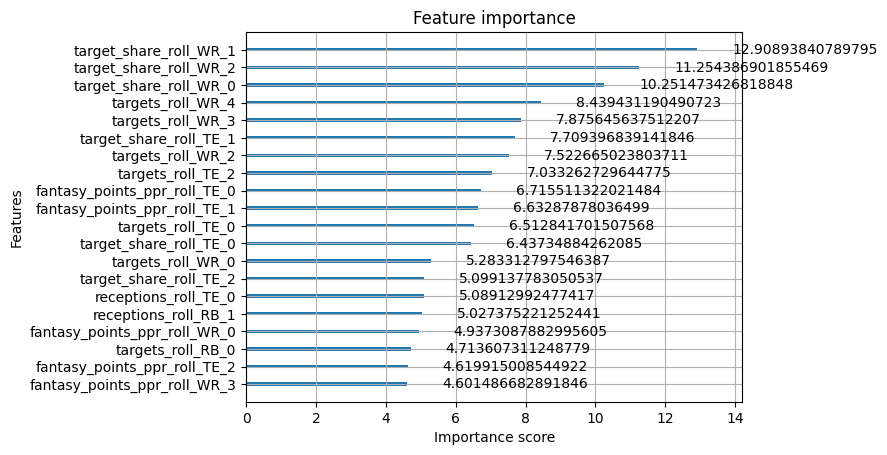

In [23]:
xgb.plot_importance(choose_receiver_model, importance_type="gain", max_num_features=20)

In [24]:
model_path = "models/choose_receiver.joblib"
feature_config = {
"receiver_idx_to_pos": receiver_idx_to_pos,
'choose_receiver_model': {
'choose_receiver_cols': choose_receiver_cols,
'model_path': model_path
}
}


In [25]:
feature_config.keys()

dict_keys(['receiver_idx_to_pos', 'choose_receiver_model'])

In [26]:
update_config(feature_config)

In [27]:
player_context = [
    "season",
    'player_display_name',
    "team",
    "week",
    "gsis_id",
    "position",
]

In [28]:
receiver_cols = [
    "dense_depth",
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_ppr_roll',
 'yards_per_catch_roll',
 'yards_per_target_roll',
 'passing_first_downs_roll',
 'offense_pct_roll']

receiver_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')
receiver_stats[receiver_cols+player_context]

,dense_depth,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_ppr_roll,yards_per_catch_roll,yards_per_target_roll,passing_first_downs_roll,offense_pct_roll,season,player_display_name,team,week,gsis_id,position
156834,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,Ryan,GB,1,00-0028156,TE
156838,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,Kevin,ATL,1,00-0028792,WR
156839,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,Frank,BUF,1,00-0026926,FB
156840,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,Tony,CHI,1,00-0027093,FB
156843,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,Dion,MIA,1,00-0030422,TE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333986,3,1.458926,2.387452,10.825928,0.112557,3.264412,6.029432,5.262341,0.0,0.527381,2025,Hunter Long,JAX,14,00-0037004,TE
333994,1,0.237994,1.299915,1.558302,0.016080,0.490305,4.489766,3.721138,0.0,0.303352,2025,Cade Stover,HOU,14,00-0039359,TE
333997,5,1.536030,2.131103,12.823545,0.015759,2.920810,6.633813,6.331169,0.0,0.607213,2025,Brandin Cooks,BUF,14,00-0031236,WR
333998,5,0.311029,0.557750,3.392202,0.000000,1.030344,5.638474,6.671291,0.0,0.424701,2025,Arian Smith,NYJ,14,00-0040582,WR


In [29]:
receiver_stats.iloc[5]

dense_depth                                       2
position                                         HB
gsis_id                                  00-0028198
player_id                                00-0028198
game_id                             2013_01_MIN_DET
season                                         2013
week                                              1
player_name                                    Matt
player_display_name                            Matt
team                                            MIN
opponent                                        DET
offense_snaps                                   0.0
offense_pct                                     0.0
passing_yards_roll                              NaN
receptions_roll                                 NaN
passing_interceptions_roll                      NaN
passing_first_downs_roll                        NaN
air_yards_share_roll                            NaN
offense_snaps_roll                              NaN
fantasy_poin

In [30]:
qb_cols = [
    'dense_depth',
    "passing_yards_roll",
    "fantasy_points_ppr_roll",
    "sacks_suffered_roll",
    "passing_yards_after_catch_roll",
    "passing_interceptions_roll",
    "passing_tds_roll",
    "offense_pct_roll",
    "passing_air_yards_roll",
    "receiving_air_yards_roll",
    "passing_first_downs_roll",
    "sack_yards_lost_roll",
    "completion_pct_roll"
]
qb_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet', columns=qb_cols+player_context)
qb_stats.loc[qb_stats.player_display_name == 'Patrick Mahomes']

,dense_depth,passing_yards_roll,fantasy_points_ppr_roll,sacks_suffered_roll,passing_yards_after_catch_roll,passing_interceptions_roll,passing_tds_roll,offense_pct_roll,passing_air_yards_roll,receiving_air_yards_roll,passing_first_downs_roll,sack_yards_lost_roll,completion_pct_roll,season,player_display_name,team,week,gsis_id,position
223812,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,Patrick Mahomes,KC,17,00-0033873,QB
225571,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,Patrick Mahomes,KC,1,00-0033873,QB
226301,0,284.000000,10.360000,2.000000,174.000000,1.000000,0.000000,0.940000,261.000000,0.000000,14.000000,-15.000000,0.628571,2018,Patrick Mahomes,KC,2,00-0033873,QB
226887,0,268.000000,20.634286,1.428571,139.142857,0.428571,2.285714,0.974286,312.428571,0.000000,11.714286,-6.428571,0.591549,2018,Patrick Mahomes,KC,3,00-0033873,QB
227698,0,293.081081,28.507027,1.243243,131.729730,0.243243,3.891892,0.985405,307.918919,0.000000,14.000000,-5.378378,0.686293,2018,Patrick Mahomes,KC,4,00-0033873,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328882,0,265.646447,25.520830,1.683031,144.760887,0.276697,2.309274,0.940691,250.234757,-0.000189,14.166746,-9.554856,0.689938,2025,Patrick Mahomes,KC,9,00-0033873,QB
330816,0,273.984835,24.880623,2.012274,151.820665,0.707523,2.481956,0.955518,242.426068,-0.000142,14.625060,-10.916142,0.701081,2025,Patrick Mahomes,KC,11,00-0033873,QB
331689,0,267.988626,21.285467,2.259205,129.865499,0.780642,1.861467,0.966639,305.069551,-0.000107,13.468795,-14.187106,0.636951,2025,Patrick Mahomes,KC,12,00-0033873,QB
332550,0,269.991470,19.299100,2.444404,142.649124,0.835482,1.646100,0.974979,309.802163,-0.000080,13.351596,-17.390330,0.639224,2025,Patrick Mahomes,KC,13,00-0033873,QB


In [31]:
qb_stats.columns = [x + '_qb'  if x in qb_cols else x for x in qb_stats.columns]
qb_cols = [x + '_qb' for x in qb_cols]

In [32]:
passes = pbp.loc[(~pbp.receiver_player_id.isna()) & (pbp.play_type_enc == 2)].copy(
    deep=True
)
passes = passes.merge(
    qb_stats,
    left_on=["posteam", "season", "week", "passer_player_id"],
    right_on=["team", "season", "week", 'gsis_id'],
)
passes = passes.merge(
    receiver_stats,
    left_on=["posteam", "season", "week", "receiver_player_id"],
    right_on=["team", "season", "week", 'gsis_id'],
    suffixes=('_qb','')
)
passes

,play_id,game_id_qb,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,passing_air_yards_roll,receiving_yards_roll,offense_pct_roll,sack_yards_lost_roll,rushing_first_downs_roll,passing_tds_roll,completion_pct_roll,yards_per_carry_roll,yards_per_catch_roll,yards_per_target_roll
0,89.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,0.0,21.637961,0.453472,0.0,2.450507,0.0,NaN,5.867742,7.463688,6.542838
1,202.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,BAL,away,NYJ,...,0.0,41.130260,0.742153,0.0,0.000000,0.0,NaN,3.000000,8.348372,6.808891
2,230.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,BAL,away,NYJ,...,0.0,17.003818,0.476948,0.0,0.145776,0.0,NaN,4.167050,6.377485,5.538112
3,301.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,BAL,away,NYJ,...,0.0,17.003818,0.476948,0.0,0.145776,0.0,NaN,4.167050,6.377485,5.538112
4,412.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64191,3156.0,2025_14_WAS_MIN,2025120705,MIN,WAS,REG,14,MIN,home,WAS,...,0.0,32.848748,0.935537,0.0,0.112148,0.0,NaN,4.311686,10.682565,5.903926
64192,3186.0,2025_14_WAS_MIN,2025120705,MIN,WAS,REG,14,MIN,home,WAS,...,0.0,0.235187,0.015137,0.0,0.000000,0.0,NaN,3.000000,4.127332,7.050933
64193,3271.0,2025_14_WAS_MIN,2025120705,MIN,WAS,REG,14,MIN,home,WAS,...,0.0,32.848748,0.935537,0.0,0.112148,0.0,NaN,4.311686,10.682565,5.903926
64194,3296.0,2025_14_WAS_MIN,2025120705,MIN,WAS,REG,14,MIN,home,WAS,...,0.0,32.848748,0.935537,0.0,0.112148,0.0,NaN,4.311686,10.682565,5.903926


In [33]:
completion_features = game_context_cols + qb_cols + receiver_cols + ['air_yards']
completion_features

['yardline_100',
 'down',
 'goal_to_go',
 'ydstogo',
 'posteam_score',
 'score_differential',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'wind',
 'temp',
 'spread_line',
 'total_line',
 'dense_depth_qb',
 'passing_yards_roll_qb',
 'fantasy_points_ppr_roll_qb',
 'sacks_suffered_roll_qb',
 'passing_yards_after_catch_roll_qb',
 'passing_interceptions_roll_qb',
 'passing_tds_roll_qb',
 'offense_pct_roll_qb',
 'passing_air_yards_roll_qb',
 'receiving_air_yards_roll_qb',
 'passing_first_downs_roll_qb',
 'sack_yards_lost_roll_qb',
 'completion_pct_roll_qb',
 'dense_depth',
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_ppr_roll',
 'yards_per_catch_roll',
 'yards_per_target_roll',
 'passing_first_downs_roll',
 'offense_pct_roll',
 'air_yards']

In [34]:
passes[completion_features]

,yardline_100,down,goal_to_go,ydstogo,posteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,...,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_ppr_roll,yards_per_catch_roll,yards_per_target_roll,passing_first_downs_roll,offense_pct_roll,air_yards
0,59.0,1.0,0.0,10.0,0.0,0.0,869.0,1769.0,3569.0,NaN,...,2.435026,3.376993,21.637961,0.000000,12.318706,7.463688,6.542838,0.0,0.453472,0.0
1,72.0,1.0,0.0,10.0,0.0,0.0,822.0,1722.0,3522.0,NaN,...,4.405876,6.068737,41.130260,0.202721,9.735229,8.348372,6.808891,0.0,0.742153,-4.0
2,68.0,2.0,0.0,6.0,0.0,0.0,801.0,1701.0,3501.0,NaN,...,2.293433,3.334296,17.003818,0.041294,4.592714,6.377485,5.538112,0.0,0.476948,3.0
3,60.0,2.0,0.0,10.0,0.0,0.0,679.0,1579.0,3379.0,NaN,...,2.293433,3.334296,17.003818,0.041294,4.592714,6.377485,5.538112,0.0,0.476948,2.0
4,91.0,2.0,0.0,12.0,0.0,0.0,551.0,1451.0,3251.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64191,81.0,2.0,0.0,8.0,31.0,31.0,430.0,430.0,430.0,NaN,...,2.449429,5.749534,32.848748,0.352913,8.033145,10.682565,5.903926,0.0,0.935537,6.0
64192,72.0,1.0,0.0,10.0,31.0,31.0,389.0,389.0,389.0,NaN,...,0.026132,0.026132,0.235187,0.000000,0.049651,4.127332,7.050933,0.0,0.015137,-2.0
64193,56.0,2.0,0.0,9.0,31.0,31.0,274.0,274.0,274.0,NaN,...,2.449429,5.749534,32.848748,0.352913,8.033145,10.682565,5.903926,0.0,0.935537,3.0
64194,44.0,1.0,0.0,10.0,31.0,31.0,229.0,229.0,229.0,NaN,...,2.449429,5.749534,32.848748,0.352913,8.033145,10.682565,5.903926,0.0,0.935537,11.0


In [35]:
def create_model(df, x_cols, y_col, colsample_bytree=0.5):
    data = df.loc[~(df[y_col].isna())].copy(deep=True)
    X, y = data[x_cols], data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = xgb.XGBClassifier(eval_metric="mlogloss", colsample_bytree=colsample_bytree)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    display(cm)
    return model

In [36]:
completion_df = passes.loc[~passes.offense_pct_roll.isna()].copy()[completion_features + ['complete_pass']]#.dropna()
#231174

In [37]:
complete_pass_model = create_model(
    completion_df, x_cols=completion_features, y_col="complete_pass", colsample_bytree=0.6
)
completion_model_path = "models/complete_pass.joblib"
joblib.dump(complete_pass_model, completion_model_path)

Accuracy: 0.70
Confusion Matrix:


array([[1366, 2755],
       [1015, 7389]])

['models/complete_pass.joblib']

In [38]:
feature_config = {
    "feature_cols": completion_features,
	'model_path':completion_model_path
}
feature_config

update_config(feature_config)

In [39]:
passes.loc[passes.air_yards > 40]['complete_pass'].value_counts(normalize=True)

complete_pass
0.0    0.719697
1.0    0.280303
Name: proportion, dtype: float64